#LAB 1: VGGNet & ResNet

<h4><div style="text-align: right"> Due date: 15:00 Oct 10, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab1.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

[link text](https://)<h2><span style="color:blue">[201924624] [Nemekhbayar Nomin]</span> </h2>

In [2]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-10-08 13:32:39.899924


In [3]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above.
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

OS information
Linux-6.1.85+-x86_64-with-glibc2.35

Is GPU available?
True

GPU information
Tue Oct  8 13:32:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360M

## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>> - **Conv2d -> BatchNorm2d -> ReLU**
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)

STEP 1: LOADING DATASET


100%|██████████| 170498071/170498071 [00:03<00:00, 47788915.66it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/


In [6]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [7]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [8]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

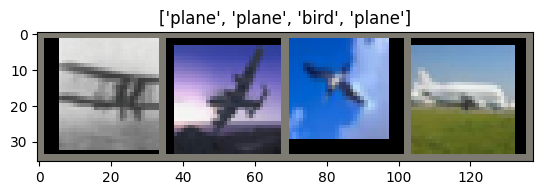

In [11]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**For the purpose of visualizing in the report**

In [ ]:
# # Create a list to store one image per class (plane, car, bird)
# sample_images = []
# sample_labels = []

# # Collect one sample from each class
# classes_needed = set([0, 1, 2])  # Assuming 0: plane, 1: car, 2: bird
# for img, label in reduced_train_dataset:
#     if label in classes_needed:
#         sample_images.append(img)
#         sample_labels.append(label)
#         classes_needed.remove(label)
#     if not classes_needed:  # Stop when we have one image from each class
#         break

# # Stack images into a single batch (for visualization purposes)
# sample_images = torch.stack(sample_images)

# # Create a grid and display the images with class names as titles
# out = torchvision.utils.make_grid(sample_images)
# imshow(out, title=[class_names[x] for x in sample_labels])


### 1.1 Write code (VGG 16) [3 points]

In [13]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

#############
# CODE HERE #
#############

## BatchNorm2d(in_channel)

cfg = [64, 64, 'MP', 128, 128, 128, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP']

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.VGG16 = self._make_layers(cfg)

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # You can adjust the size here if necessary
        self.classifier = nn.Linear(512 * 7 * 7, 3)  # This should be consistent with the flattened size

    def forward(self, x):
        out = self.VGG16(x)
        out = self.avgpool(out)  # Apply adaptive pooling

        out = out.view(out.size(0), -1)  # Flatten the output
        # print(f"Shape after flattening: {out.shape}")  # Print flattened shape for verification

        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'MP':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, x, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        return nn.Sequential(*layers)


STEP 3: CREATE MODEL CLASS (VGG16)


In [14]:
print('STEP 4: INSTANTIATE MODEL CLASS')

vgg_model = VGG()
num_total_params = sum(p.numel() for p in vgg_model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  12879555


VGG(
  (VGG16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-0

In [15]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()  # commonly used for multi-class classification

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4


# The Stochastic Gradient Descent (SGD) optimizer is instantiated with a specified learning rate (1e-2),
# Momentum helps accelerate gradients in the right direction,
# while weight decay adds regularization to prevent overfitting.
optimizer = torch.optim.SGD(vgg_model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [16]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

#############
# CODE HERE #
# Initialize lists to store metrics
train_accuracy = []
train_loss = []

# Training loop
for epoch in range(num_epochs):
    vgg_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = vgg_model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (index of the highest logit)
        total += labels.size(0)  # Total samples in the batch
        correct += (predicted == labels).sum().item()  # Sum up the correct predictions

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_loss = 100 * correct / total

    # Store metrics for plotting
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

#############



STEP 7: TRAIN THE MODEL
Epoch [1/20], Loss: 4.0003, Accuracy: 37.66%
Epoch [2/20], Loss: 1.6856, Accuracy: 36.33%
Epoch [3/20], Loss: 1.4299, Accuracy: 36.96%
Epoch [4/20], Loss: 1.3052, Accuracy: 37.61%
Epoch [5/20], Loss: 1.1276, Accuracy: 38.24%
Epoch [6/20], Loss: 1.1292, Accuracy: 42.77%
Epoch [7/20], Loss: 1.0737, Accuracy: 52.41%
Epoch [8/20], Loss: 0.8915, Accuracy: 57.34%
Epoch [9/20], Loss: 0.8253, Accuracy: 60.10%
Epoch [10/20], Loss: 0.7993, Accuracy: 67.41%
Epoch [11/20], Loss: 0.7034, Accuracy: 71.12%
Epoch [12/20], Loss: 0.6849, Accuracy: 73.35%
Epoch [13/20], Loss: 0.5997, Accuracy: 76.32%
Epoch [14/20], Loss: 0.5798, Accuracy: 77.91%
Epoch [15/20], Loss: 0.5459, Accuracy: 79.28%
Epoch [16/20], Loss: 0.5161, Accuracy: 80.46%
Epoch [17/20], Loss: 0.5143, Accuracy: 80.08%
Epoch [18/20], Loss: 0.4778, Accuracy: 81.59%
Epoch [19/20], Loss: 0.4468, Accuracy: 82.69%
Epoch [20/20], Loss: 0.4222, Accuracy: 83.62%


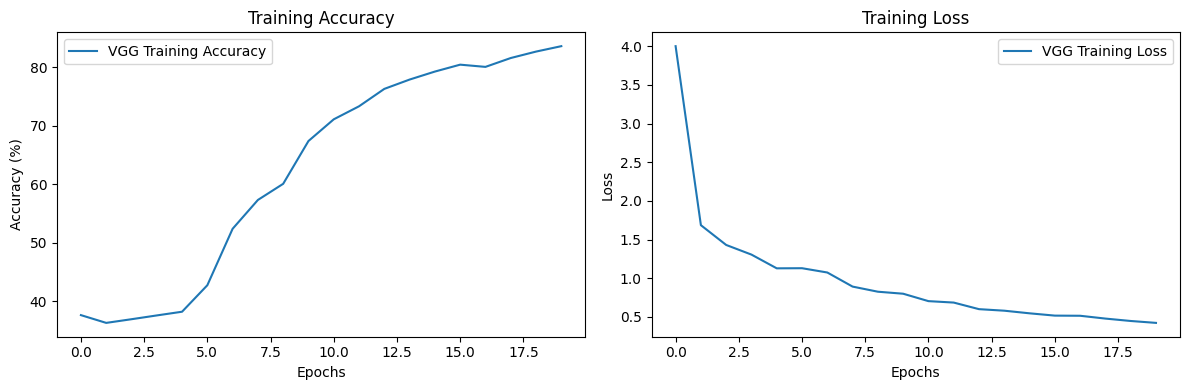

In [17]:
import matplotlib.pyplot as plt

# Visualization of Training Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='VGG Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='VGG Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br>
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points]

In [18]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

cfg = [3,4,6,3]


# Resnet mini Network
class ResNet_block(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample = False):
        super(ResNet_block, self).__init__()
        self.down_sample = down_sample
        self.expand = (in_c != out_c)

        # First 1x1 convolution layer
        self.conv1 = nn.Conv2d(in_c, intra_c, kernel_size=1, stride=2 if down_sample else 1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(intra_c)

        # Second 3x3 convolution layer
        self.conv2 = nn.Conv2d(intra_c, intra_c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intra_c)

        # Third 1x1 convolution layer
        self.conv3 = nn.Conv2d(intra_c, out_c, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_c)

        # 1x1 convolution layer for down-sampling and expanding the channel dimensions of the identity connection
        self.convert_id = nn.Sequential()
        if self.down_sample or self.expand:
            self.convert_id = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=2 if down_sample else 1, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))


        if self.down_sample or self.expand:
            identity = self.convert_id(x)

        out = F.relu(out + identity)
        return out



# ResNet general Network
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        num_classes = 3

        self.init_block = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # defining the ResNet blocks according to cfg
        self.ResBlock1 = self._make_layers(64, 64, 256, num_block=3, down_sample=False)
        self.ResBlock2 = self._make_layers(256, 128, 512, num_block=4, down_sample=True)
        self.ResBlock3 = self._make_layers(512, 256, 1024, num_block=6, down_sample=True)
        self.ResBlock4 = self._make_layers(1024, 512, 2048, num_block=3, down_sample=True)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)



    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.ResBlock3(out)
        out = self.ResBlock4(out)
        out = self.avgpool(out)
        out= out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        # first block
        layers.append(ResNet_block(in_c = in_c, intra_c = intra_c, out_c = out_c, down_sample = down_sample))
        # intermediate blocks
        for _ in range(num_block - 1):
            layers.append(ResNet_block(in_c = out_c, intra_c = intra_c, out_c = out_c, down_sample = False))

        return nn.Sequential(*layers)


print('STEP 4: INSTANTIATE MODEL CLASS')
#############
# CODE HERE #
resnet_model = ResNet()
print(resnet_model)
#############


STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS
ResNet(
  (init_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ResBlock1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convert_id): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

### 2.2 Print test accuracy for every epochs. [1 points]

In [19]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()  # commonly used for multi-class classification

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4


optimizer = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

print('STEP 7: TRAIN THE MODEL')

num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)


res_train_accuracy = []
res_train_loss = []


for epoch in range(num_epochs):
  resnet_model.train()

  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_loader:

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = resnet_model(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_accuracy = 100 * correct / total

  # Store metrics for plotting
  res_train_loss.append(epoch_loss)
  res_train_accuracy.append(epoch_accuracy)

  accuracy = 100 * correct / total
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epoch [1/15], Loss: 1.1153, Accuracy: 58.03%
Epoch [2/15], Loss: 0.6455, Accuracy: 75.41%
Epoch [3/15], Loss: 0.5110, Accuracy: 80.32%
Epoch [4/15], Loss: 0.4301, Accuracy: 83.79%
Epoch [5/15], Loss: 0.5163, Accuracy: 81.18%
Epoch [6/15], Loss: 0.3920, Accuracy: 85.53%
Epoch [7/15], Loss: 0.3367, Accuracy: 87.11%
Epoch [8/15], Loss: 0.2867, Accuracy: 88.78%
Epoch [9/15], Loss: 0.2500, Accuracy: 90.33%
Epoch [10/15], Loss: 0.2194, Accuracy: 91.69%
Epoch [11/15], Loss: 0.1948, Accuracy: 92.53%
Epoch [12/15], Loss: 0.1593, Accuracy: 93.89%
Epoch [13/15], Loss: 0.1241, Accuracy: 95.49%
Epoch [14/15], Loss: 0.1180, Accuracy: 95.69%
Epoch [15/15], Loss: 0.1044, Accuracy: 96.20%


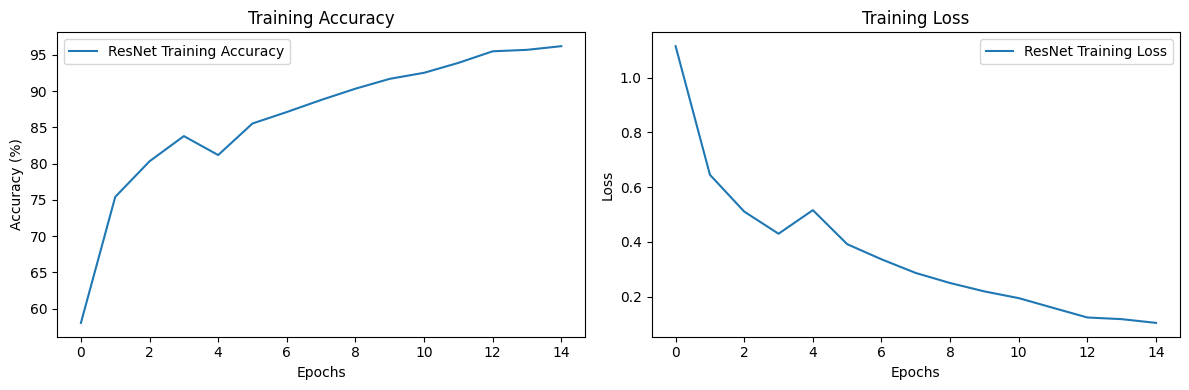

In [20]:
import matplotlib.pyplot as plt

# Visualization of Training Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(res_train_accuracy, label='ResNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(res_train_loss, label='ResNet Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = test_loss / len(test_loader)
    return accuracy, average_loss


In [22]:

# Evaluate VGG on test data
vgg_test_accuracy, vgg_test_loss = test_model(vgg_model, test_loader)
# Evaluate ResNet on test data
resnet_test_accuracy, resnet_test_loss = test_model(resnet_model, test_loader)


In [28]:
print(f'VGG Testing', vgg_test_accuracy, vgg_test_loss)
print(f'ResNet Testing', resnet_test_accuracy, resnet_test_loss)

VGG Testing 83.36666666666666 0.43024213512738546
ResNet Testing 89.66666666666667 0.5285450379053752


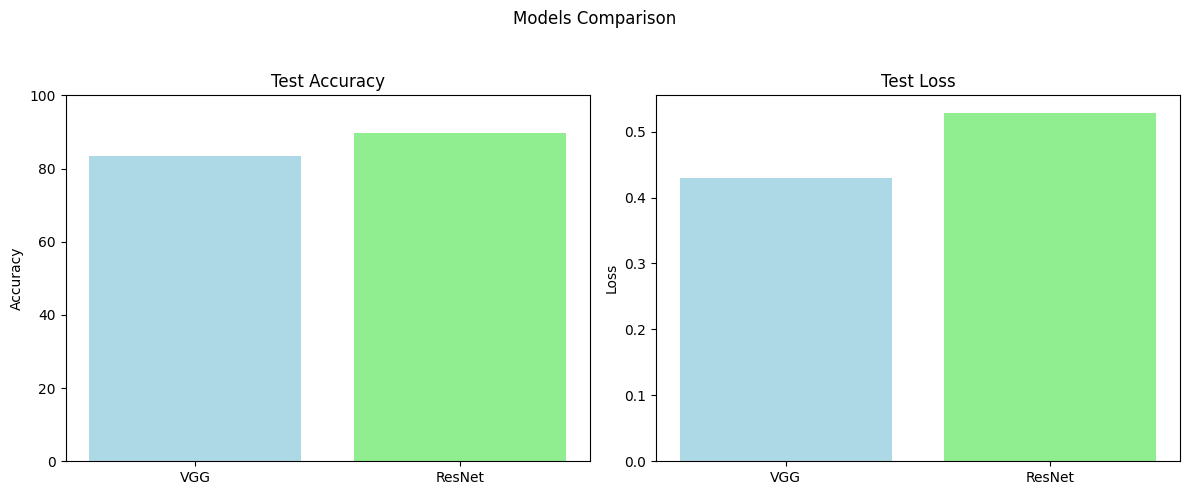

In [27]:
import matplotlib.pyplot as plt

# Data for the models
model_names = ['VGG', 'ResNet']
test_accuracies = [vgg_test_accuracy, resnet_test_accuracy]
test_losses = [vgg_test_loss, resnet_test_loss]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Models Comparison')  # Set title for the entire figure

# Define softer colors
colors = ['lightblue', 'lightgreen']

# Accuracy plot
axs[0].bar(model_names, test_accuracies, color=colors)
axs[0].set_title('Test Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 100)

# Loss plot
axs[1].bar(model_names, test_losses, color=colors)
axs[1].set_title('Test Loss')
axs[1].set_ylabel('Loss')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


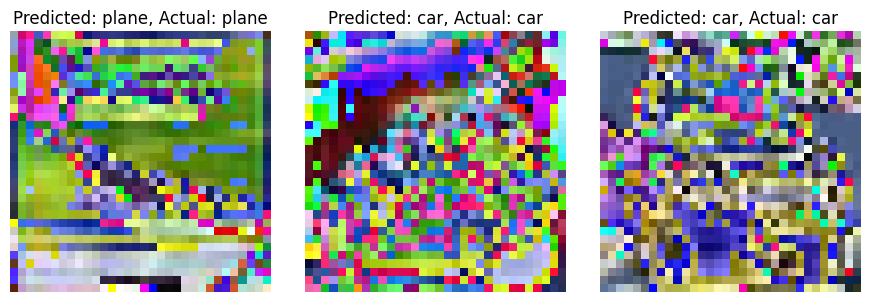

In [35]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Define class labels
class_labels = ['plane', 'car', 'bird']

# Function to visualize random samples from the test dataset
def visualize_predictions(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    transform_to_pil = transforms.ToPILImage()

    # Pick a random batch of images from the test loader
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Get the model's predictions for these images
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    # Plot the first three images
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    for i in range(3):
        image = images[i].cpu()
        label = labels[i].cpu().item()
        pred = predictions[i].cpu().item()

        # Convert to PIL Image for display
        image_pil = transform_to_pil(image)

        # Map numeric labels to class names
        actual_label_name = class_labels[label]
        predicted_label_name = class_labels[pred]

        axes[i].imshow(image_pil)
        axes[i].set_title(f"Predicted: {predicted_label_name}, Actual: {actual_label_name}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize predictions for VGG model
visualize_predictions(vgg_model, test_loader)
# Optionally, for ResNet model as well
# visualize_predictions(resnet_model, test_loader)
